### Packages and Settings

In [1]:
# System pacakges
import os
import sys
import re
import gc
import time
import datetime
import warnings

# Data pacakges
import pickle
import numpy as np
import pandas as pd
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt

# Modelling pacakges
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

# Pacakge settings
%matplotlib inline
sns.set(style="darkgrid")
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sys.version_info

sys.version_info(major=3, minor=8, micro=3, releaselevel='final', serial=0)

### Load data

In [2]:
train = pd.read_csv("/Users/roblespaeza96/Desktop/DT Certificate /Caps/capstone-project/sales_train.csv")
items = pd.read_csv("/Users/roblespaeza96/Desktop/DT Certificate /Caps/capstone-project/items.csv")
# Drop name to save space
items = items.drop('item_name', axis=1)
# Set index to ID to avoid droping it later
test  = pd.read_csv("/Users/roblespaeza96/Desktop/DT Certificate /Caps/capstone-project/test.csv").set_index('ID')
# Add date_block_num = 34
test['date_block_num'] = 34


### Compress data size

In [3]:
# Get the ranges of each feature to select the most appropriate data size
print ('-------------------------------------------------------')
print ('train:')
for f in train.columns.values:
    print ('%s: %s ~ %s' %(f, train[f].min(), train[f].max()))
print ('-------------------------------------------------------')
print ('items:')
for f in items.columns.values:
    print ('%s: %s ~ %s' %(f, items[f].min(), items[f].max()))
print ('-------------------------------------------------------')
print ('test:')
for f in test.columns.values:
    print ('%s: %s ~ %s' %(f, test[f].min(), test[f].max()))

-------------------------------------------------------
train:
date: 01.01.2013 ~ 31.12.2014
date_block_num: 0 ~ 33
shop_id: 0 ~ 59
item_id: 0 ~ 22169
item_price: -1.0 ~ 307980.0
item_cnt_day: -22.0 ~ 2169.0
-------------------------------------------------------
items:
item_id: 0 ~ 22169
item_category_id: 0 ~ 83
-------------------------------------------------------
test:
shop_id: 2 ~ 59
item_id: 30 ~ 22167
date_block_num: 34 ~ 34


In [4]:
def compress_columns(df,columns,keyword,search_type,datatype):
    if search_type=='in':
        valid_features = [x for x in columns if keyword in x]
    elif search_type=='start':
        valid_features = [x for x in columns if x.startswith(keyword)]
    if len(valid_features):
        for f in valid_features:
            df[f] = df[f].round().astype(datatype)
    return df

def data_compression(df):
    features = df.columns.values
    # Original features
    if 'date_block_num' in features:
        df['date_block_num'] = df['date_block_num'].astype(np.int8)
    if 'shop_id' in features:
        df['shop_id'] = df['shop_id'].astype(np.int8)
    if 'item_category_id' in features:
        df['item_category_id'] = df['item_category_id'].astype(np.int8)
    if 'item_id' in features:
        df['item_id'] = df['item_id'].astype(np.int16)
    if 'item_price' in features:
        df['item_price'] = df['item_price'].astype(np.float32)
    if 'item_id_avg_item_price' in features:
        df['item_id_avg_item_price'] = df['item_id_avg_item_price'].astype(np.float32)
        
    # Mean encoded features & lag features
    df = compress_columns(df,features,'item_id_sum_item_cnt_day','in',np.int16)
    df = compress_columns(df,features,'item_id_avg_item_cnt_day','in',np.float16)
    
    df = compress_columns(df,features,'shop_id_avg_item_price','in',np.float16)
    df = compress_columns(df,features,'shop_id_sum_item_cnt_day','in',np.int16)
    df = compress_columns(df,features,'shop_id_avg_item_cnt_day','in',np.float16)
    
    df = compress_columns(df,features,'item_category_id_avg_item_price','in',np.float16)
    df = compress_columns(df,features,'item_category_id_sum_item_cnt_day','in',np.int32)
    df = compress_columns(df,features,'item_category_id_avg_item_cnt_day','in',np.float16)
    
    df = compress_columns(df,features,'item_cnt_day','start',np.int16)
    return df

In [5]:
# Compress features according to range
train = data_compression(train)
items = data_compression(items)
test = data_compression(test)

In [6]:
# Include Category id
train = pd.merge(train,items,on='item_id',how='left')
test = pd.merge(test,items, on='item_id', how='left')

In [7]:
#Merge duplicated shops
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

### Check Feature Distributions

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 7 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date              object 
 1   date_block_num    int8   
 2   shop_id           int8   
 3   item_id           int16  
 4   item_price        float32
 5   item_cnt_day      int16  
 6   item_category_id  int8   
dtypes: float32(1), int16(2), int8(3), object(1)
memory usage: 75.6+ MB


**Plot the feature distributions**

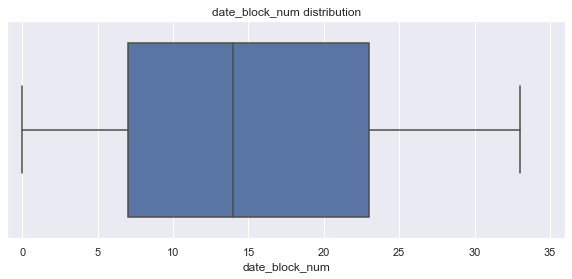

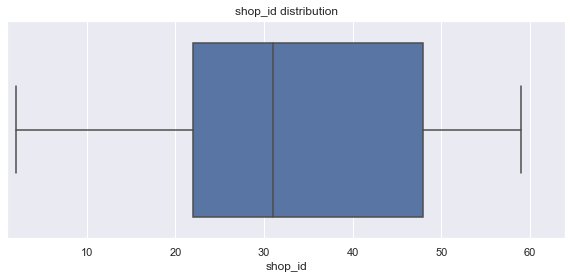

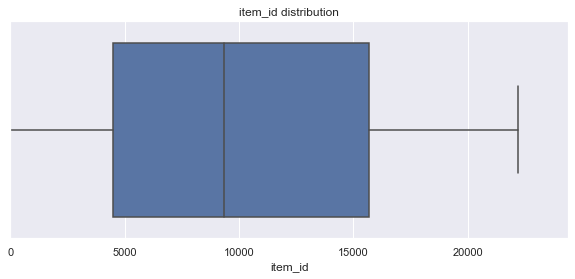

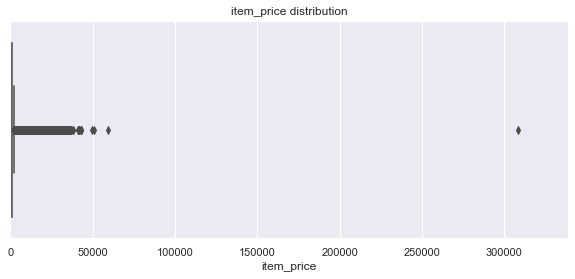

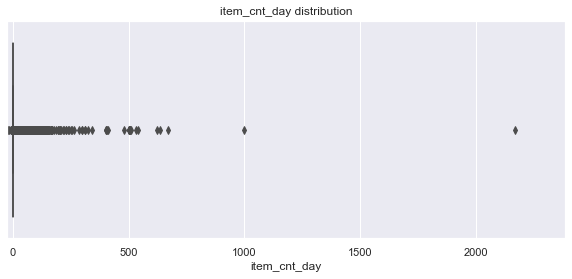

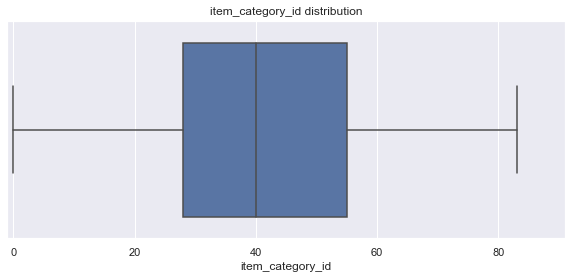

In [9]:
def box_plot(df,f):
    plt.figure(figsize=(10,4))
    plt.title(f+' distribution')
    x_min = int(df[f].min() - (abs(df[f].min())*0.1))
    x_max = int(df[f].max() + (abs(df[f].max())*0.1))
    if x_min==0:
        x_min = -1
    if x_max==0:
        x_max = 1
    plt.xlim(x_min,x_max)
    sns.boxplot(x=df[f])

plot_features = [x for x in train.columns.values if train[x].dtype != 'object']
for f in plot_features:
    box_plot(train,f)

### Outliers removal

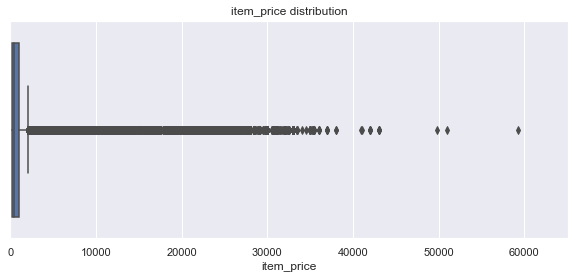

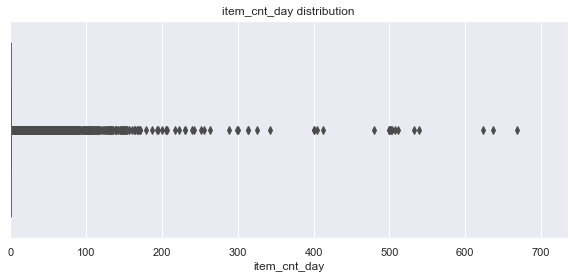

In [10]:
# Getting rid of the outliers & negative values
train = train[(train['item_price']<100000) & (train['item_price']>=0)]
train = train[(train['item_cnt_day']<1000) & (train['item_cnt_day']>=0)]

# distribution after outliers removal
plot_features = ['item_price','item_cnt_day']
for f in plot_features:
    box_plot(train,f)

### Create a dataframe of all Date_block_num, Store and Item combinations:
So in case in the months some shops did not have the sale record of some item, it can be set to 0.

In [11]:
# Create a grid with columns
index_cols = ['shop_id','item_id','date_block_num']

# For every month we create a grid for all shops/items pair
grid = []
for block_num in train['date_block_num'].unique():
    cur_shops = train.loc[train['date_block_num']==block_num,'shop_id'].unique()
    cur_items = train.loc[train['date_block_num']==block_num,'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops,cur_items,[block_num]])),dtype='int32'))
grid = pd.DataFrame(np.vstack(grid),columns=index_cols,dtype=np.int32)
grid = data_compression(grid)
grid.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [12]:
grid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10884508 entries, 0 to 10884507
Data columns (total 3 columns):
 #   Column          Dtype
---  ------          -----
 0   shop_id         int8 
 1   item_id         int16
 2   date_block_num  int8 
dtypes: int16(1), int8(2)
memory usage: 41.5 MB


In [13]:
# Create Mean Encodings
# Group items per month, per shop, per item, sum the sales of the item, mean the price
# There is a big difference between np.mean and pandas mean
train_m = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day':'sum','item_price':np.mean}).reset_index()
train_m = pd.merge(grid,train_m,on=['date_block_num','shop_id','item_id'],how='left').fillna(0)
train_m = pd.merge(train_m,items,on='item_id',how='left')
train_m = data_compression(train_m)

In [14]:
# Making the mean encoded features
for type_id in ['item_id', 'shop_id', 'item_category_id']:
    for column_id, aggregator, aggtype in [('item_price',np.mean,'avg'),('item_cnt_day',np.sum,'sum'),('item_cnt_day',np.mean,'avg')]:
        mean_df = train.groupby([type_id,'date_block_num']).aggregate(aggregator).reset_index()[[column_id,type_id,'date_block_num']]
        mean_df.columns = [type_id+'_'+aggtype+'_'+column_id,type_id,'date_block_num']
        train_m = pd.merge(train_m, mean_df, on=['date_block_num',type_id], how='left')
        del mean_df
        gc.collect()

In [15]:
del train
gc.collect()

22

### Fill NaNs

In [16]:
for f in train_m.columns:
    if 'item_cnt' in f:
        train_m[f] = train_m[f].fillna(0)
    elif 'item_price' in f:
        train_m[f] = train_m[f].fillna(train_m[f].median())

# Compress data
train_m = data_compression(train_m)
train_m.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10884508 entries, 0 to 10884507
Columns: 15 entries, shop_id to item_category_id_avg_item_cnt_day
dtypes: float16(5), float32(2), int16(4), int32(1), int8(3)
memory usage: 425.6 MB


### Create Lag Features

In [17]:
# Check the positions of the base lag features
train_m.columns.values[6:]

array(['item_id_avg_item_price', 'item_id_sum_item_cnt_day',
       'item_id_avg_item_cnt_day', 'shop_id_avg_item_price',
       'shop_id_sum_item_cnt_day', 'shop_id_avg_item_cnt_day',
       'item_category_id_avg_item_price',
       'item_category_id_sum_item_cnt_day',
       'item_category_id_avg_item_cnt_day'], dtype=object)

In [18]:
# Get all the monthly features, which means the Mean Encoded fatures are all monthly based
lag_features = list(train_m.columns[6:])+['item_cnt_day']
# The selected months from current month
lags = [1,2,3,6]

In [19]:
for lag in lags:
    train_new_df = train_m.copy()
    # Get the current month
    train_new_df['date_block_num'] += lag
    train_new_df = train_new_df[['date_block_num','shop_id','item_id']+lag_features]
    # Name the columns as lag features of the month
    train_new_df.columns = ['date_block_num','shop_id','item_id'] + [x+'_lag_'+str(lag) for x in lag_features]
    train_m = pd.merge(train_m,train_new_df,on=['date_block_num','shop_id','item_id'],how='left')
    del train_new_df
    gc.collect()
    print ('lag %s processed' %lag)

lag 1 processed
lag 2 processed
lag 3 processed
lag 6 processed


In [20]:
# Fill NaNs
for f in train_m.columns:
    if 'item_cnt' in f:
        train_m[f] = train_m[f].fillna(0)
    elif 'item_price' in f:
        train_m[f] = train_m[f].fillna(train_m[f].median())

train_m = data_compression(train_m)
train_m.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10884508 entries, 0 to 10884507
Columns: 55 entries, shop_id to item_cnt_day_lag_6
dtypes: float16(25), float32(6), int16(16), int32(5), int8(3)
memory usage: 1.4 GB


### Clipping train data to make it similar to test set

In [21]:
# Set the maximum clip value
max_clip = 30
train_m['item_cnt_day'] = train_m['item_cnt_day'].clip(0,max_clip).astype(np.float16)

### Prepare test set

In [22]:
# Add lag variables
for lag in lags:
    train_new_df = train_m.copy()
    # Get the current month
    train_new_df['date_block_num'] += lag
    train_new_df = train_new_df[['date_block_num','shop_id','item_id']+lag_features]
    # Name the columns as lag features of the month
    train_new_df.columns = ['date_block_num','shop_id','item_id'] + [x+'_lag_'+str(lag) for x in lag_features]
    test = pd.merge(test,train_new_df,on=['date_block_num','shop_id','item_id'],how='left')
    del train_new_df
    gc.collect()
    print ('lag %s processed' %lag)

lag 1 processed
lag 2 processed
lag 3 processed
lag 6 processed


In [23]:
# Fill NaNs
for f in test.columns:
    if 'item_cnt' in f:
        test[f] = test[f].fillna(0)
    elif 'item_price' in f:
        test[f] = test[f].fillna(test[f].median())

test = data_compression(test)

### Drop all columns which are not lag features

In [24]:
cols_to_drop = lag_features[:-1] + ['item_price']
print ('Columns to drop')
print (cols_to_drop)

Columns to drop
['item_id_avg_item_price', 'item_id_sum_item_cnt_day', 'item_id_avg_item_cnt_day', 'shop_id_avg_item_price', 'shop_id_sum_item_cnt_day', 'shop_id_avg_item_cnt_day', 'item_category_id_avg_item_price', 'item_category_id_sum_item_cnt_day', 'item_category_id_avg_item_cnt_day', 'item_price']


In [25]:
train_cols = train_m.columns.values
test_cols = test.columns.values
for c in cols_to_drop:
    if c in train_cols:
        train_m = train_m.drop(c,axis=1)
    if c in test_cols:
        test = test.drop(c,axis=1)

### Create new time related features

In [26]:
# Month number
train_m['month'] = train_m['date_block_num']%12
train_m['month'] = train_m['month'].astype(np.int8)
# Number of days in a month, no leap years here
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
train_m['days'] = train_m['month'].map(days).astype(np.int8)

test['month'] = 11
test['month'] = test['month'].astype(np.int8)
test['days'] = 30
test['days'] = test['days'].astype(np.int8)

### Check if lag variables in test set are correct

In [27]:
# Assert all the columns are the same except target column
set(train_m.columns.values) ^ set(test.columns.values)

{'item_cnt_day'}

In [28]:
train_m.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_category_id,item_id_avg_item_price_lag_1,item_id_sum_item_cnt_day_lag_1,item_id_avg_item_cnt_day_lag_1,shop_id_avg_item_price_lag_1,shop_id_sum_item_cnt_day_lag_1,shop_id_avg_item_cnt_day_lag_1,item_category_id_avg_item_price_lag_1,item_category_id_sum_item_cnt_day_lag_1,item_category_id_avg_item_cnt_day_lag_1,item_cnt_day_lag_1,item_id_avg_item_price_lag_2,item_id_sum_item_cnt_day_lag_2,item_id_avg_item_cnt_day_lag_2,shop_id_avg_item_price_lag_2,shop_id_sum_item_cnt_day_lag_2,shop_id_avg_item_cnt_day_lag_2,item_category_id_avg_item_price_lag_2,item_category_id_sum_item_cnt_day_lag_2,item_category_id_avg_item_cnt_day_lag_2,item_cnt_day_lag_2,item_id_avg_item_price_lag_3,item_id_sum_item_cnt_day_lag_3,item_id_avg_item_cnt_day_lag_3,shop_id_avg_item_price_lag_3,shop_id_sum_item_cnt_day_lag_3,shop_id_avg_item_cnt_day_lag_3,item_category_id_avg_item_price_lag_3,item_category_id_sum_item_cnt_day_lag_3,item_category_id_avg_item_cnt_day_lag_3,item_cnt_day_lag_3,item_id_avg_item_price_lag_6,item_id_sum_item_cnt_day_lag_6,item_id_avg_item_cnt_day_lag_6,shop_id_avg_item_price_lag_6,shop_id_sum_item_cnt_day_lag_6,shop_id_avg_item_cnt_day_lag_6,item_category_id_avg_item_price_lag_6,item_category_id_sum_item_cnt_day_lag_6,item_category_id_avg_item_cnt_day_lag_6,item_cnt_day_lag_6,month,days
0,59,22154,0,1.00,37,299.00,0,0.00,879.00,0,0.00,379.00,0,0.00,0,299.00,0,0.00,872.00,0,0.00,379.00,0,0.00,0,299.00,0,0.00,868.00,0,0.00,376.00,0,0.00,0,299.00,0,0.00,847.00,0,0.00,376.00,0,0.00,0,0,31
1,59,2552,0,0.00,58,299.00,0,0.00,879.00,0,0.00,379.00,0,0.00,0,299.00,0,0.00,872.00,0,0.00,379.00,0,0.00,0,299.00,0,0.00,868.00,0,0.00,376.00,0,0.00,0,299.00,0,0.00,847.00,0,0.00,376.00,0,0.00,0,0,31
2,59,2554,0,0.00,58,299.00,0,0.00,879.00,0,0.00,379.00,0,0.00,0,299.00,0,0.00,872.00,0,0.00,379.00,0,0.00,0,299.00,0,0.00,868.00,0,0.00,376.00,0,0.00,0,299.00,0,0.00,847.00,0,0.00,376.00,0,0.00,0,0,31
3,59,2555,0,0.00,56,299.00,0,0.00,879.00,0,0.00,379.00,0,0.00,0,299.00,0,0.00,872.00,0,0.00,379.00,0,0.00,0,299.00,0,0.00,868.00,0,0.00,376.00,0,0.00,0,299.00,0,0.00,847.00,0,0.00,376.00,0,0.00,0,0,31
4,59,2564,0,0.00,59,299.00,0,0.00,879.00,0,0.00,379.00,0,0.00,0,299.00,0,0.00,872.00,0,0.00,379.00,0,0.00,0,299.00,0,0.00,868.00,0,0.00,376.00,0,0.00,0,299.00,0,0.00,847.00,0,0.00,376.00,0,0.00,0,0,31


In [29]:
test.head()

,shop_id,item_id,date_block_num,item_category_id,item_id_avg_item_price_lag_1,item_id_sum_item_cnt_day_lag_1,item_id_avg_item_cnt_day_lag_1,shop_id_avg_item_price_lag_1,shop_id_sum_item_cnt_day_lag_1,shop_id_avg_item_cnt_day_lag_1,item_category_id_avg_item_price_lag_1,item_category_id_sum_item_cnt_day_lag_1,item_category_id_avg_item_cnt_day_lag_1,item_cnt_day_lag_1,item_id_avg_item_price_lag_2,item_id_sum_item_cnt_day_lag_2,item_id_avg_item_cnt_day_lag_2,shop_id_avg_item_price_lag_2,shop_id_sum_item_cnt_day_lag_2,shop_id_avg_item_cnt_day_lag_2,item_category_id_avg_item_price_lag_2,item_category_id_sum_item_cnt_day_lag_2,item_category_id_avg_item_cnt_day_lag_2,item_cnt_day_lag_2,item_id_avg_item_price_lag_3,item_id_sum_item_cnt_day_lag_3,item_id_avg_item_cnt_day_lag_3,shop_id_avg_item_price_lag_3,shop_id_sum_item_cnt_day_lag_3,shop_id_avg_item_cnt_day_lag_3,item_category_id_avg_item_price_lag_3,item_category_id_sum_item_cnt_day_lag_3,item_category_id_avg_item_cnt_day_lag_3,item_cnt_day_lag_3,item_id_avg_item_price_lag_6,item_id_sum_item_cnt_day_lag_6,item_id_avg_item_cnt_day_lag_6,shop_id_avg_item_price_lag_6,shop_id_sum_item_cnt_day_lag_6,shop_id_avg_item_cnt_day_lag_6,item_category_id_avg_item_price_lag_6,item_category_id_sum_item_cnt_day_lag_6,item_category_id_avg_item_cnt_day_lag_6,item_cnt_day_lag_6,month,days
0,5,5037,34,19,1499.00,25,1.00,1028.00,1054,1.00,1680.00,2450,1.00,0,936.68,111,1.00,1037.00,1098,1.00,1360.00,3998,1.00,1,894.59,119,1.00,911.00,1297,1.00,1140.00,4674,1.00,3,1542.87,87,1.00,959.00,1013,1.00,1418.00,3407,1.00,1,11,30
1,5,5320,34,55,449.00,0,0.00,1240.00,0,0.00,510.00,0,0.00,0,432.00,0,0.00,1204.00,0,0.00,511.00,0,0.00,0,437.10,0,0.00,969.00,0,0.00,488.00,0,0.00,0,437.75,0,0.00,1099.00,0,0.00,559.00,0,0.00,0,11,30
2,5,5233,34,19,1199.00,42,1.00,1028.00,1054,1.00,1680.00,2450,1.00,1,711.71,80,1.00,1037.00,1098,1.00,1360.00,3998,1.00,3,712.15,150,1.00,911.00,1297,1.00,1140.00,4674,1.00,1,790.03,71,1.00,959.00,1013,1.00,1418.00,3407,1.00,3,11,30
3,5,5232,34,23,1190.14,29,1.00,1028.00,1054,1.00,1796.00,2213,1.00,0,703.49,48,1.00,1037.00,1098,1.00,1269.00,3610,1.00,0,642.47,65,1.00,911.00,1297,1.00,1164.00,3666,1.00,1,437.75,0,0.00,1099.00,0,0.00,559.00,0,0.00,0,11,30
4,5,5268,34,20,449.00,0,0.00,1240.00,0,0.00,510.00,0,0.00,0,432.00,0,0.00,1204.00,0,0.00,511.00,0,0.00,0,437.10,0,0.00,969.00,0,0.00,488.00,0,0.00,0,437.75,0,0.00,1099.00,0,0.00,559.00,0,0.00,0,11,30


It seems that the order of the columns are the same for train & test.<br>
(Except for the target column 'item_cnt_day')

In [30]:
test[['shop_id','item_id']+['item_cnt_day_lag_'+str(x) for x in [1,2,3]]].head()

,shop_id,item_id,item_cnt_day_lag_1,item_cnt_day_lag_2,item_cnt_day_lag_3
0,5,5037,0,1,3
1,5,5320,0,0,0
2,5,5233,1,3,1
3,5,5232,0,0,1
4,5,5268,0,0,0


In [31]:
print(train_m[train_m['shop_id'] == 5][train_m['item_id'] == 5037][train_m['date_block_num'] == 33]['item_cnt_day'])
print(train_m[train_m['shop_id'] == 5][train_m['item_id'] == 5037][train_m['date_block_num'] == 32]['item_cnt_day'])
print(train_m[train_m['shop_id'] == 5][train_m['item_id'] == 5037][train_m['date_block_num'] == 31]['item_cnt_day'])

10820113   0.00
Name: item_cnt_day, dtype: float16
10581628   1.00
Name: item_cnt_day, dtype: float16
10372045   3.00
Name: item_cnt_day, dtype: float16


### Take the recent bit of data
Data too far in the past are considered to be less relevant

In [32]:
train_m = train_m[train_m['date_block_num']>12]

### Split into train & validation
Validation: The last month 'date_block_num'==33<br>
Train: Everything else

In [33]:
train_set = train_m[train_m['date_block_num']<33]
val_set = train_m[train_m['date_block_num']==33]

In [34]:
print (train_set.shape)
print (val_set.shape)
print (test.shape)

(5820464, 47)
(238084, 47)
(214200, 46)


### Export the preprocessed data

In [35]:
# Save data
train_set.to_pickle('train.pkl')
val_set.to_pickle('val.pkl')
test.to_pickle('test.pkl')

In [36]:
del train_m
gc.collect()

22

Modelling
3 distinctively different models are used:
1. Ridge Regression (Linear)
2. xgboost (Tree based)
3. Random Forest (Tree based)

After each model has been trained, a stacked ensemble model which includes the above 3 are been trained as well.

**Data preparation**

In [37]:
# divide data into x & y
train_x = train_set.drop(['item_cnt_day'],axis=1)
train_y = train_set['item_cnt_day']
val_x = val_set.drop(['item_cnt_day'],axis=1)
val_y = val_set['item_cnt_day']

features = list(train_x.columns.values)

In [38]:
# Check if the data sets have equal amount of features
print (train_x.shape)
print (train_y.shape)
print (val_x.shape)
print (val_y.shape)
print (test.shape)

(5820464, 46)
(5820464,)
(238084, 46)
(238084,)
(214200, 46)


In [40]:
del train_set
del val_set
gc.collect()

0

In [41]:
# For saving data & output results / models
def post_processing(model,model_name,train_x,val_x,test_x,train_y,val_y,test):
    # Here we once again clip the output to 0~20
    train_pred = model.predict(train_x).clip(0, 20)
    val_pred = model.predict(val_x).clip(0, 20)
    test_pred = model.predict(test_x).clip(0, 20)

    # Get rmse scores
    train_rmse = np.sqrt(mean_squared_error(train_y, train_pred))
    print("Train RMSE: %f" % (train_rmse))
    val_rmse = np.sqrt(mean_squared_error(val_y, val_pred))
    print("Val RMSE: %f" % (val_rmse))
    
    # Export submission
    submission = pd.DataFrame({'ID':test.index,'item_cnt_month': test_pred})
    submission.to_csv('%s_submission.csv'%model_name,index=False)

    # save model to file
    pickle.dump(lm, open("%s_model.pickle" %model_name, "wb"))
    return train_pred,val_pred,test_pred

In [42]:
# For plotting feature importance
def plot_feature_importances(importances,indices,features,title,dimensions):
    plt.figure(figsize=dimensions)
    plt.title(title)
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()   

### Ridge Regression

In [43]:
# Normalise data
scaler = preprocessing.StandardScaler()
scaler.fit(train_x.values)
train_x_norm = scaler.transform(train_x.values)
val_x_norm = scaler.transform(val_x.values)
test_norm = scaler.transform(test.values)

In [44]:
# Training
gc.collect()
ts = time.time()
# Training
lm = linear_model.Ridge()
lm.fit(train_x_norm,train_y)
print ('Training time: %s' %(time.time() - ts))

Training time: 4.964299440383911


In [45]:
# Performance and test predictions
train_pred1,val_pred1,test_pred1 = post_processing(lm,'ridge',train_x_norm,val_x_norm,test_norm,train_y,val_y,test)

Train RMSE: 1.153216
Val RMSE: 1.169679


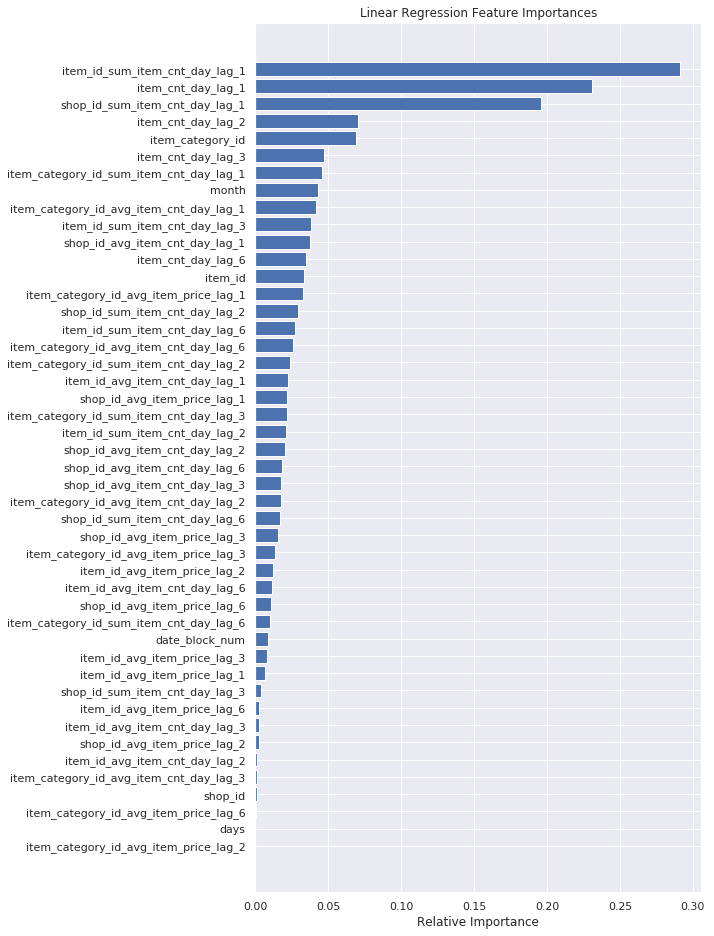

In [46]:
# Feature Importance
importances = abs(lm.coef_)
indices = np.argsort(importances)
title = 'Linear Regression Feature Importances'
plot_feature_importances(importances,indices,features,title,(8,16))

In [47]:
del train_x_norm
del val_x_norm
del test_norm
gc.collect()

6731

### xgboost

In [48]:
# Training
gc.collect()
ts = time.time()
xgbtrain = xgb.DMatrix(train_x.values, train_y.values)

param = {'max_depth':8, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':1000, 
         'seed':1,
         'verbosity':2,
         'eval_metric':'rmse'} # random parameters

bst = xgb.train(param, xgbtrain)
print ('Training time: %s' %(time.time() - ts))

[00:30:18] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[00:31:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 476 extra nodes, 0 pruned nodes, max_depth=8
[00:31:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=8
[00:32:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 476 extra nodes, 0 pruned nodes, max_depth=8
[00:32:55] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 488 extra nodes, 0 pruned nodes, max_depth=8
[00:33:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=8
[00:34:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=8
[00:34

In [49]:
# Performance and test predictions
train_pred2,val_pred2,test_pred2 = post_processing(bst,'xgboost',xgb.DMatrix(train_x.values),xgb.DMatrix(val_x.values),xgb.DMatrix(test.values),train_y,val_y,test)

Train RMSE: 0.952974
Val RMSE: 1.077657


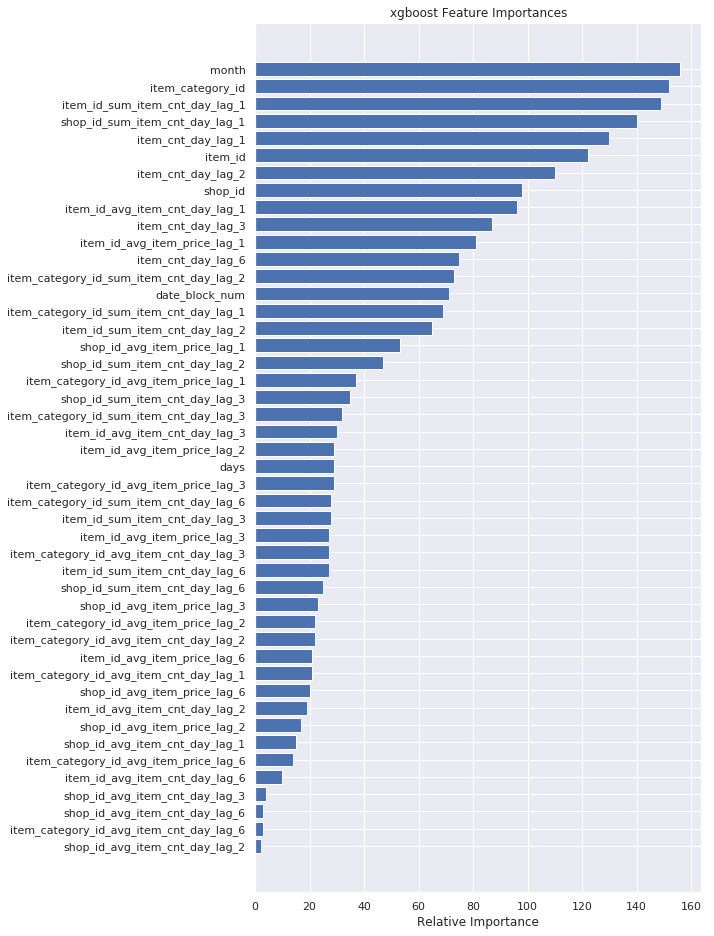

In [50]:
# Feature Importance
import operator
importance = sorted(bst.get_score().items(), key=operator.itemgetter(1))
importance_v = np.asarray([x[1] for x in importance],dtype=np.int16)
indices = np.asarray([int(x[0].replace('f','')) for x in importance],dtype=np.int8)
title = 'xgboost Feature Importances'

plt.figure(figsize=(8,16))
plt.title(title)
plt.barh(range(len(indices)), importance_v, color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()   

### Random Forest

In [51]:
# Training
gc.collect()
ts = time.time()
rf = RandomForestRegressor(
    bootstrap=True,
    max_depth=30,
    max_features=3,
    min_samples_leaf=5,
    min_samples_split=12,
    n_estimators=200,
    random_state=42,
    verbose=1,
    n_jobs=-1
)
rf.fit(train_x.values,train_y.values)
print ('Training time: %s' %(time.time() - ts))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 23.8min


Training time: 1490.1836333274841


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 24.8min finished


In [52]:
# Performance and test predictions
train_pred3,val_pred3,test_pred3 = post_processing(rf,'rf',train_x,val_x,test,train_y,val_y,test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   32.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  2.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    5.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    4.5s finished


Train RMSE: 0.720878
Val RMSE: 1.052174


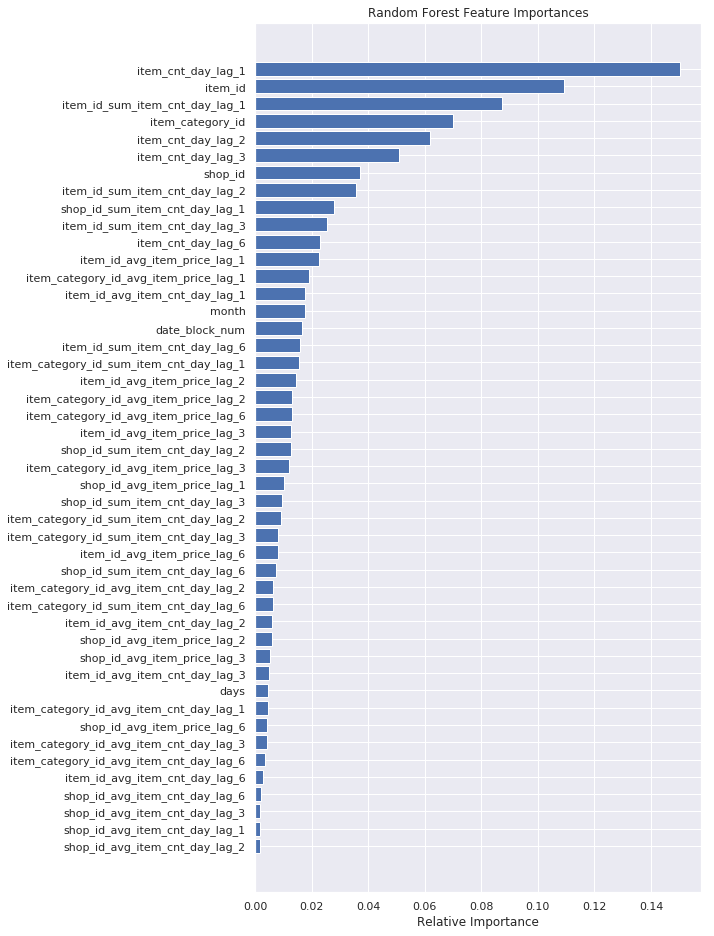

In [53]:
# Feature Importance
importances = rf.feature_importances_
indices = np.argsort(importances)
title = 'Random Forest Feature Importances'
plot_feature_importances(importances,indices,features,title,(8,16))

## Stacking
Use previous results to do stacking instead of rerunning all the models again.<br>
It saves time and computation resources.

In [54]:
# Making data
train_stack = pd.DataFrame({'lm':train_pred1,'xgboost':train_pred2,'rf':train_pred3})
val_stack = pd.DataFrame({'lm':val_pred1,'xgboost':val_pred2,'rf':val_pred3})
test_stack = pd.DataFrame({'lm':test_pred1,'xgboost':test_pred2,'rf':test_pred3})

In [55]:
# Normalise data
scaler = preprocessing.StandardScaler()
scaler.fit(train_stack.values)
train_stack = scaler.transform(train_stack.values)
val_stack = scaler.transform(val_stack.values)
test_stack = scaler.transform(test_stack.values)

In [56]:
# Training
gc.collect()
ts = time.time()
# Training
stack_lm = linear_model.Ridge()
stack_lm.fit(train_stack,train_y)
print ('Training time: %s' %(time.time() - ts))

Training time: 0.3823983669281006


In [57]:
# Performance and test predictions
post_processing(stack_lm,'stack',train_stack,val_stack,test_stack,train_y,val_y,test)

Train RMSE: 0.667797
Val RMSE: 1.077787


(array([0.71730153, 0.17213309, 2.46025839, ..., 0.        , 0.        ,
        0.        ]),
 array([0.01463041, 1.25234718, 0.48188362, ..., 0.12076665, 0.        ,
        0.        ]),
 array([1.04254927, 0.53962342, 1.58146722, ..., 0.00496113, 0.        ,
        0.        ]))

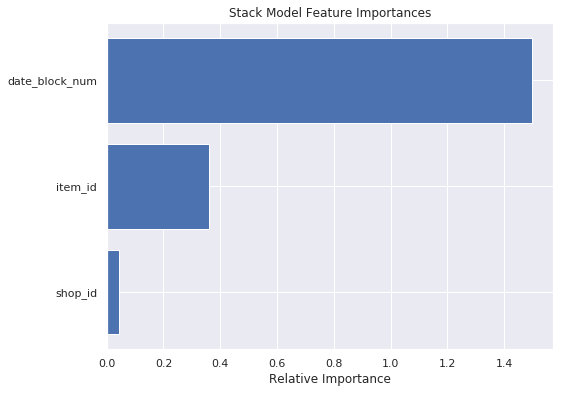

In [58]:
# Feature Importance
importances = abs(stack_lm.coef_)
indices = np.argsort(importances)
title = 'Stack Model Feature Importances'
plot_feature_importances(importances,indices,features,title,(8,6))